## <center> **Анализ результатов A/B-тестирования**

Компания планирует запустить новую акцию, чтобы продать как можно больше туров. Команда разработала два варианта посадочной страницы официального сайта компании и провела A/B-тестирование. Собранные в результате проведения эксперимента данные вы можете найти здесь.

Вам предстоит решить настоящую бизнес-задачу: проанализировать эффективность обоих вариантов посадочной страницы сразу по двум критериям: конверсии покупки и среднему чеку. На основе проведенного анализа вам будет необходимо сделать выводы и принять решение: какой из вариантов дизайна более предпочтительный.

Итак, наша фирма предлагает следующие варианты туров и их соответствующие стоимости:
* Таиланд — 100000 рублей;
* Турция — 60000 рублей;
* Мальдивы — 200000 рублей;
* Санкт-Петербург — 10000 рублей;
* Камчатка — 150000 рублей.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from scipy.stats import t
from scipy.stats import ttest_ind, shapiro, f_oneway, mannwhitneyu
from statsmodels.stats.proportion import proportions_ztest

Прочитаем наши данные и посмотрим на столбцы таблицы:

In [2]:
data = pd.read_csv('data/ab_data_tourist.csv')
data.head()

,user_id,date,group,purchase,price
0,851104,2021-01-21,A,0,0
1,804228,2021-01-12,A,0,0
2,661590,2021-01-11,B,0,0
3,853541,2021-01-08,B,0,0
4,864975,2021-01-21,A,1,150000


## **Задание 7.1.**

Начнем с исследования структуры наших данных. С помощью метода info() выведите информацию о типах данных и количестве непустых значений. Какой тип данных имеет столбец date?

In [3]:
# ваш код здесь
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   user_id   294478 non-null  int64 
 1   date      294478 non-null  object
 2   group     294478 non-null  object
 3   purchase  294478 non-null  int64 
 4   price     294478 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 11.2+ MB


## **Задание 7.2.**

Приведите столбец date к типу данных datetime. Убедитесь в равной длительности проведения тестирования для каждой из группы. Для этого сгруппируйте данные по признаку группы и определите первую и последнюю дату наблюдения для каждой из групп. 

В какой промежуток времени проводился A/B-тест?


In [4]:
# преобразуем признак год из объекта в дату
data['date'] = pd.to_datetime(data['date'])

# группируем данные по группам
data.groupby('group')['date'].agg(['min', 'max'])

,min,max
group,,
A,2021-01-02,2021-01-24
B,2021-01-02,2021-01-24


## **Задание 7.3.**

* Чему равно количество посещений сайта в группах А и B?

* Чему равно суммарное количество покупок в группах А и B?

* Чему равна сумма всех покупок в группах А и B? Ответ приведите в миллионах рублей. Например, 185.52 млн. руб.

In [5]:
print('Количество посещений сайта в группах А и B: \n {}'.format(data.groupby('group')['user_id'].agg('count')))

print('\n Суммарное количество покупок в группах А и B: \n {}'.format(data.groupby('group')['purchase'].agg('sum')))

print('\n Суммарное количество покупок в группах А и B: \n {}'.format(data.groupby('group')['price'].agg('sum') / 1e6))

Количество посещений сайта в группах А и B: 
 group
A    147202
B    147276
Name: user_id, dtype: int64

 Суммарное количество покупок в группах А и B: 
 group
A    17723
B    17514
Name: purchase, dtype: int64

 Суммарное количество покупок в группах А и B: 
 group
A    1436.26
B    1554.10
Name: price, dtype: float64


## **Задание 7.4.**

Проверьте, есть ли пользователи, которые в процессе A/B-теста попали в обе тестовые группы? Если да, то сколько таких уникальных пользователей, если нет - введите в поле для ответа 0?

**Подсказка:**

*Создайте множество пользователей группы А и множество пользователей группы B. Пересеките два этих множества (операция intersection) и вычислите количество элементов в полученном множестве.*


In [6]:
# Множество группы "А"
a_data = data[data['group'] == 'A']

# Множество группы "Б"
b_data = data[data['group'] == 'B']

# Находим пересечения множеств (intersection)
ab_intersection = set(a_data['user_id']).intersection(set(b_data['user_id']))
print('Пересечений:', len(ab_intersection))

Пересечений: 1895


## **Исключите пользователей, оказавшихся в обеих группах**

Так как мы не можем определить, какая из версий сайта повлияла на принятие решения, исключим этих пользователей. Далее мы будем работать только с очищенными от пересечений данными.

Возможный вариант исключения пользователей:

In [7]:
updated_data = data[data['user_id'].apply(lambda x: x not in ab_intersection)]

Где user_intersection - множество пересечений пользователей групп А и B.

## **Задание 7.5.**

Для первичного анализа результатов A/B-тестирования нам понадобится таблица следующего вида:

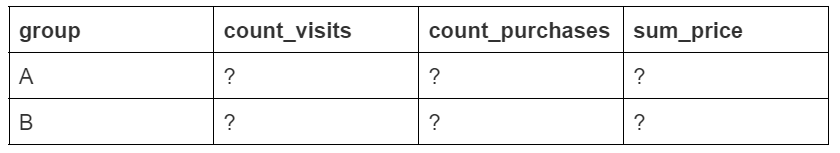
 
 
Для того, чтобы получить такую таблицу, сгруппируйте данные по признаку группы. В каждой группе рассчитайте следующие показатели:
* количество посещений (количество пользователей)
* количество совершенных покупок
* сумма всех покупок в группе

В полученной сгруппированной таблице переименуйте столбцы на **count_visits, count_purchases и sum_price**.

**Подсказка:**

*Для переименования столбцов можно использовать метод rename() с параметром columns, в который передается словарь. Ключи этого словаря - старые имена столбцов, а значения - новые.*

Чему на этот раз равно количество посещений сайта в группах А и B?


In [8]:
data_grouped = updated_data.groupby('group').agg({
    'user_id': 'count',
    'purchase': 'sum',
    'price': 'sum'
})

data_grouped =data_grouped.rename(columns={
    'user_id':'count_visits',
    'purchase':'count_purchases',
    'price':'sum_price'
})

data_grouped



,count_visits,count_purchases,sum_price
group,,,
A,145307,17487,1417780000
B,145381,17290,1533010000


Приведите промежуточные выводы по построенной таблице. Сопоставимо ли количество посещений обоих вариантов посадочной странице, можно ли говорить о сбалансированности выборок?

Вывод: разница в выборке посещений имеет разницу в 74 единицы, что составляет 0,05%. Можно сказать данная выборка сбалансирована.

## **Задание 7.6.**

Добавьте в сгруппированную таблицу столбцы conversion - конверсия покупки (отношение количества покупок к количеству посещений сайта в каждой группе, выраженное в процентах) и mean_check - средний чек (отношение суммы покупок к количеству покупок в каждой группе).

* Чему равна конверсия в группах? Ответ приведите в процентах и округлите до сотых. Например, 75.12 %
* Чему равен средний чек в группах? Ответ приведите в рублях и округлите до целых. Например, 120519 рублей.

In [10]:
# Вычисляем конверсию (%)
data_grouped['conversion'] = data_grouped['count_purchases'] / data_grouped['count_visits'] * 100

# Вычисляем средний чек
data_grouped['mean_check'] = round(data_grouped['sum_price'] / data_grouped['count_purchases'])

print('Конверсия: \n {}'.format((data_grouped['conversion']).round(2)))
print('\nСредний чек: \n {}'.format((data_grouped['mean_check']).round()))

Конверсия: 
 group
A    12.03
B    11.89
Name: conversion, dtype: float64

Средний чек: 
 group
A    81076.0
B    88665.0
Name: mean_check, dtype: float64


Приведите промежуточные выводы по таблице. По какому(им) показателю(ям) вариант А эффективнее варианта B и наоборот?

Вывод:<br>
Вариант А эффективнее вартанта В по конверсии на 0.14%.
<br>Но также вариант А уступает по эффективности варанту В по среднему чеку на 7589 руб.

## **Задание 7.7.**

Теперь давайте сравним варианты по покупательской способности туров. Для этого постройте сводную таблицу, которая покажет зависимость количества продаж от группы и цены тура. 

In [11]:
pivot = updated_data[updated_data['price']>0].pivot_table(
    index='group',
    columns='price',
    values='purchase',
    aggfunc='sum'
)

In [12]:
pivot

price,10000,60000,100000,150000,200000
group,,,,,
A,5182,5271,1832,3478,1724
B,5201,1730,5227,3438,1694


Визуализируйте полученную сводную таблицу с помощью тепловой карты с аннотацией. 
Чему равно количество проданных туров за 60000 рублей в группах?

Text(0.5, 1.0, 'Тепловая карта покупательской способности в группах')

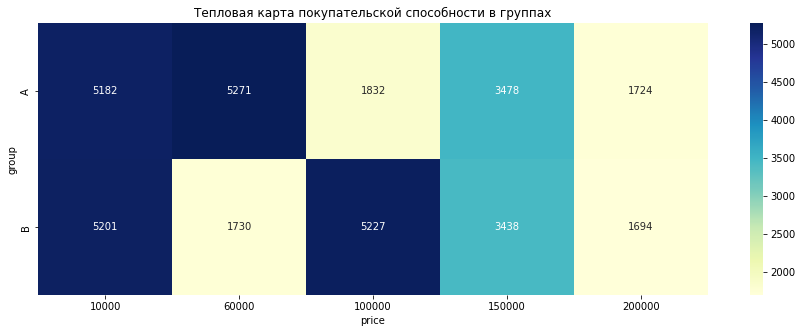

In [13]:
fig = plt.figure(figsize=(15, 5))
ax = sns.heatmap(pivot, fmt='.0f', annot=True, cmap='YlGnBu')
ax.set_title('Тепловая карта покупательской способности в группах')

Сделайте выводы по построенной таблице. По каким турам покупательская способность участников группы А выше, чем участников группы B и наоборот?

Вывод: на тепловой карте явно выделена высокая покупательская способность в группа А, чем в группе В на туры за 60 000 руб. Но в группе В высокая покупательская способность туров по 100 000 руб. По остальным турам разница покупательской способности отличается незначительно.

## **Задание 7.8.**

Настало время поговорить о стабилизации кумулятивных метрик во времени. Но прежде, чем перейти к кумулятивным метрикам, нам необходимо построить таблицу с ежедневными данными результатов проведения A/B-тестирования.

Сгруппируйте данные по дате и группе тестирования. В каждой группе вычислите количество посещений страницы, количество покупок и сумму покупок. 

Добавьте в таблицу информацию о ежедневной конверсии (ежедневное количество покупок / ежедневное количество посещений) в группе и ежедневном среднем чеке (ежедневная сумма покупок / ежедневное количество покупок)
* Чему равна конверсия 3 января 2021 года? Ответ приведите в процентах и округлите до сотых.

* Чему равен средний чек 3 января 2021 года? Ответ приведите в рублях и округлите до целого.

In [14]:
# Группируем по дате и по группе
daily_data = updated_data.groupby(['date', 'group']).agg({
    'user_id':'count',
    'purchase':'sum',
    'price':'sum'
}).reset_index()

# Переименовываем столбцы
daily_data = daily_data.rename(columns={
    'user_id':'count_visits',
    'purchase':'count_purchases',
    'price':'sum_price'
})

# Добавляем ежедневную конверсию
daily_data['conversion'] = daily_data['count_purchases'] / daily_data['count_visits'] * 100

# Добавляем ежедневный средний чек
daily_data['mean_check'] = daily_data['sum_price'] / daily_data['count_purchases']

# конверсия 3 января 2021 года
day_conv = daily_data[daily_data['date'] == '2021-01-03'][['group', 'conversion']].round(2)

# средний чек 3 января 2021 года
day_mean_check = daily_data[daily_data['date'] == '2021-01-03'][['group', 'mean_check']].round()

print('Конверсия 3 января 2021 года равна\n', day_conv)
print('\nСредний чек 3 января 2021 года равен\n', day_mean_check)

Конверсия 3 января 2021 года равна
   group  conversion
2     A       11.34
3     B       11.39

Средний чек 3 января 2021 года равен
   group  mean_check
2     A     82888.0
3     B     87480.0


## **Задание 7.9.** 

Добавьте в таблицу с ежедневными показателями кумулятивные признаки:
* кумулятивное количество посещений страницы
* кумулятивное количество покупок
* кумулятивную сумму покупок

Не забудьте при расчете кумулятивной суммы сгруппировать данные по группам. 

Вычислите кумулятивную конверсию и кумулятивный средний чек на основе полученных кумулятивных показателей. 

* Какая **кумулятивная** конверсия была в группе B на 20 января 2021? Ответ приведите в процентах, округлив до сотых.
* Какой **кумулятивный** средний чек был в группе А на 12 января 2021 года? Ответ приведите в рублях, округлив до целых.

In [15]:
# кумулятивное количество посещений страницы
daily_data['cum_count_visits'] = daily_data.groupby('group')['count_visits'].cumsum()

# кумулятивное количество покупок
daily_data['cum_count_purchases'] = daily_data.groupby('group')['count_purchases'].cumsum()

# кумулятивную сумму покупок
daily_data['cum_sum_price'] = daily_data.groupby('group')['sum_price'].cumsum()

# кумулятивная конверсия
daily_data['cum_conversion'] = daily_data['cum_count_purchases'] / daily_data['cum_count_visits'] * 100

# кумулятивный средний чек
daily_data['cum_mean_check'] = daily_data['cum_sum_price'] / daily_data['cum_count_purchases']

In [16]:
# кумулятивная конверсия в группе B на 20 января 2021
cum_conv = daily_data[daily_data['date'] == '2021-01-20'][['group', 'cum_conversion']].round(2)
cum_conv = cum_conv[cum_conv['group'] == 'B']

# кумулятивный средний чек в группе А на 12 января 2021
cum_check = daily_data[daily_data['date'] == '2021-01-12'][['group', 'cum_mean_check']].round()
cum_check = cum_check[cum_check['group'] == 'A']

print('Кумулятивная конверсия 20 января 2021 года равна:\n', cum_conv)
print('\nКумулятивный средний чек 12 января 2021 года равен:\n', cum_check)

Кумулятивная конверсия 20 января 2021 года равна:
    group  cum_conversion
37     B            11.9

Кумулятивный средний чек 12 января 2021 года равен:
    group  cum_mean_check
20     A         81492.0


Постройте кумулятивные графики конверсии и среднего чека в каждой группе по дням. Сделайте выводы. Можно ли назвать A/B-тест завершенным - стабилизировались ли значения метрик во времени? Как соотносятся кумулятивные показатели в каждой группе?

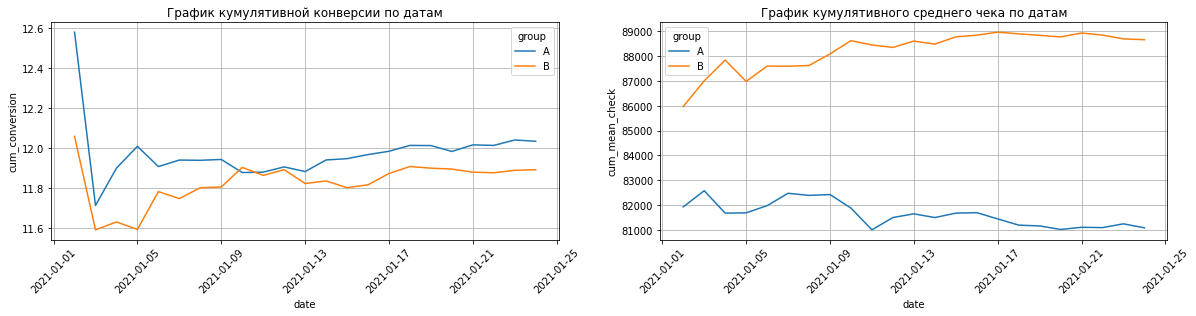

In [17]:
# задаем размер и количество графиков в строке
fig, axes=plt.subplots(1, 2, figsize=(20, 4))

# строим линейный график кумулятивной конверсии по группам
sns.lineplot(x='date', y='cum_conversion', data=daily_data, hue='group', ax=axes[0])

# строим линейный график кумулятивного среднего чека по группам
sns.lineplot(x='date', y='cum_mean_check', data=daily_data, hue='group', ax=axes[1])

# наименования графиков
axes[0].set_title('График кумулятивной конверсии по датам')
axes[1].set_title('График кумулятивного среднего чека по датам')

# поворот надписей на оси "Х"
axes[0].xaxis.set_tick_params(rotation = 45)
axes[1].xaxis.set_tick_params(rotation = 45)

# отрисовываем сетку на графиках
axes[0].grid(True);
axes[1].grid(True);

Вывод:<br>
График кумулятивной конверсии стабилизировался во второй половине примерно с 14.01.2021. Конверсия в группе А выше, чем в группе В примерно на 0,15%, разница несущественная.<br>
График кумулятивного среднего чека стабилизировался во второй половине примерно с 15.01.2021. Значение кумулятивного среднего чека в группе В выше, чем в группе А примерно на 7 600 руб.<br>
А/В тестирование еще не завершено т.к. мы не провели статистические тесты и не сформулировали выводы для принятия решения.

## **Задание 7.10.**

Настало время переходить к проверке статистической значимости разницы между метриками в группах. Начнем с конверсии.

Какой тест вы примените для проверки гипотезы о равенстве конверсий в группах?

Проведите тестирование при следующих нулевой и альтернативной гипотезе:
* $H_0$: Конверсии в группах А и B равны; 
* $H_1$: Конверсия в группе А больше чем конверсия в группе B;

Вычислите p-value вашего теста для конверсий в группах А и B. Сравните полученное значение p-value с уровнем значимости $\alpha$=0.05. 

In [24]:
# применим z-тестирование для пропорций
# считаем сколько раз было совершено целевое действие (покупка тура) и количество наблюдений (посещений сайта)
converted_piv = data.groupby('group')['purchase'].agg(['sum', 'count'])

# выдвигаем гипотезы
H0 = 'Конверсии в группах А и B равны'
H1 = 'Конверсия в группе А больше чем конверсия в группе B'
alpha = 0.05 # уровень значимости
# считаем значение p-value для z-теста для пропорций
_, p_value = proportions_ztest(
    count=converted_piv['sum'], # число покупок
    nobs=converted_piv['count'], # общее число наблюдений (посещений сайта)
    alternative='larger'
)
# вывод p-value
print('p-value: ', round(p_value, 2))

#проверяем гопотезы
if (p_value < alpha): 
    print("Отвергаем нулевую гипотезу. {}".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))

p-value:  0.11
Принимаем нулевую гипотезу. Конверсии в группах А и B равны


In [19]:
display(converted_piv)

,sum,count
group,,
A,17723,147202
B,17514,147276


Приведите свои выводы по результатам проведенного статистического теста. Есть ли статистическая разница между конверсиями в группах А и B?

Вывод:
Z-тестирование показало, что значение p-value больше,чем значение "альфа", соответственно принимается нулевая гипотеза, где конверсиями в группах А и B равна.
Нулевая гипотеза подтверждается также при альфа равной 1% и 10%.

## **Задание 7.11.**
Убедитесь в своих рассуждениях, построив 95%-ый доверительный интервал для конверсий и разницы между ними. Используйте $z_{крит}$ в своих расчетах

Укажите нижнюю и верхнюю границы доверительных интервалов. Границы приведите в процентах и округлите до 2 знака после запятой. Например: нижняя граница 89.24%, верхняя граница 91.25%.

In [33]:
def conversion_conf_interval(n, x_p, gamma=0.95):

    alpha = 1 - gamma # уровень значимости
    z_crit = -norm.ppf(alpha/2) # z-критическое
    eps = z_crit * (x_p * (1 - x_p) / n) ** 0.5 # погрешность
    lower_bound = x_p - eps # левая (нижняя) граница
    upper_bound = x_p + eps # правая (верхняя) граница

    # возвращаем кортеж из округленных границ интервала
    return round(lower_bound * 100, 2), round(upper_bound * 100, 2)

# фильтруем группу А
a_data = updated_data[updated_data['group'] == 'A']
# фильтруем группу В
b_data = updated_data[updated_data['group'] == 'B']

conf_interval_a = conversion_conf_interval(
a_data['user_id'].count(), # размер выборки
a_data['purchase'].mean() # выборочная пропорция
)

conf_interval_b = conversion_conf_interval(
b_data['user_id'].count(), # размер выборки
b_data['purchase'].mean() # выборочная пропорция
)

display('Доверительный интервал для конверсии группы А: {}'.format(conf_interval_a))
display('Доверительный интервал для конверсии группы B: {}'.format(conf_interval_b))

'Доверительный интервал для конверсии группы А: (11.87, 12.2)'

'Доверительный интервал для конверсии группы B: (11.73, 12.06)'

Проинтерпретируйте построенные доверительные интервалы для конверсий в группах. Есть ли перекрытие между доверительными интервалами для групп? Есть ли статистическая разница между конверсиями в группах А и B?

Вывод: Из расчета видно, что интервалы пересекаются, значит есть вероятность совпадения истинного значенич конверсии в двух группах

In [34]:
# строим доверительный интервал для разницы конверсий

def diff_conversion_conf_interval(n, xp, gamma=0.95):
    alpha = 1 - gamma # уровень значимости
    diff = xp[1] - xp[0] # выборочная разница конверсий групп B и A
    z_crit = -norm.ppf(alpha/2) #z критическое
    eps = z_crit * (xp[0] * (1 - xp[0])/n[0] + xp[1] * (1 - xp[1])/n[1]) ** 0.5 # погрешность
    lower_bound = diff - eps # левая (нижняя) граница
    upper_bound = diff + eps # правая (верхняя) граница
    # возвращаем кортеж - границы интервала
    return round(lower_bound *100, 2), round(upper_bound * 100, 2)

# размеры выборок в группах А и B
n = [a_data['user_id'].count(), b_data['user_id'].count()]

# выборочная пропорция в группах A и B
xp = [a_data['purchase'].mean(), b_data['purchase'].mean()]

# строим доверительный интервал для разности конверсий
diff_inverval = diff_conversion_conf_interval(n, xp)

display('Доверительный интервал для разности конверсий: {}'.format(diff_inverval)) 

'Доверительный интервал для разности конверсий: (-0.38, 0.09)'

Вывод: Расчет доверительного интервала для разности конверсий показывает, что нижняя граница отрицательная, а верхняя граница положительная. Т-дельта = Р(В) - Р(А) может быть положительной либо отрицательной, следовательно варианты А и В равнозначны.
Расчеты были проверены с альфой равной 1% и 10% - результат не изменился, А и В равнозначны

## **Задание 7.12.**

Ранее мы построили таблицу с ежедневными показателями. Теперь она нам снова понадобится, так как нас интересует ежедневный средний чек.

Проверьте гипотезу о нормальности распределения ежедневного среднего чека в каждой из групп тестирования. 

* Какой тест вы примените  для проверки гипотезы о нормальности распределения ежедневного среднего чека?
* Как будут звучать нулевая и альтернативная гипотезы?
* Каковы результаты статистического теста с уровнем значимости $\alpha$ =0.05?

In [38]:
# выдвигаем гипотезы
H0 = 'Распределения в обеих группах нормальные'
H1 = 'Распределение в одной или обеих группах отлично от нормального'
alpha = 0.05 # альфа - уровень значимости

# фильтруем группа А 
daily_data_a = daily_data[daily_data['group'] == 'A']
# фильтруем группу В
daily_data_b = daily_data[daily_data['group'] == 'B']
 
# тест Шапиро-Уилка для выборок
shapiro_result_a = shapiro(daily_data_a['mean_check'])
display('p-value группы А', round(shapiro_result_a.pvalue, 2))

shapiro_result_b = shapiro(daily_data_b['mean_check'])
display('p-value группы B', round(shapiro_result_b.pvalue, 2))

# сравниваем полученное p-value с уровнем значимости
if shapiro_result_a.pvalue < alpha or shapiro_result_b.pvalue < alpha:
    display("Отвергаем нулевую гипотезу. {}".format(H0))
    display("Альтернативная гипотеза. H1: {}".format(H1))
else:
    display("Принимаем нулевую гипотезу. {}".format(H0))

'p-value группы А'

0.25

'p-value группы B'

0.09

'Принимаем нулевую гипотезу. Распределения в обеих группах нормальные'

## **Задание 7.13.**
Настало время сравнить варианты дизайна страницы по метрике среднего чека. 

Какой тест вы примените для проверки гипотезы о равенстве средних чеков по дням в группах?

Проведите тестирование при следующих нулевой и альтернативной гипотезе:
* $H_0$: Ежедневные средние чеки в группах А и B равны; 
* $H_1$: Ежедневный средний чек в группе А меньше чем в группе B;

Вычислите p-value вашего теста для ежедневного среднего чека в группах А и B. Сравните полученное значение p-value с уровнем значимости $\alpha$ =0.05. 

In [41]:
# выдвигаем гипотезы
H0 = 'Ежедневные средние чеки в группах А и B равны'
H1 = 'Ежедневный средний чек в группе А меньше чем в группе B'
alpha = 0.05 # альфа - уровень значимости

# фильтруем группу А 
daily_data_a = daily_data[daily_data['group'] == 'A']

# фильтруем группу В
daily_data_b = daily_data[daily_data['group'] == 'B']
 
# используем T-тест для выборки
results = ttest_ind(
    daily_data_a['mean_check'],
    daily_data_b['mean_check'],
    alternative='less' # меньше
)
display('p-value:', round(results.pvalue, 2))
 
if results.pvalue < alpha:
    display("Отвергаем нулевую гипотезу. {}".format(H0))
    display("Альтернативная гипотеза. H1: {}".format(H1))
else:
    display("Принимаем нулевую гипотезу. {}".format(H0))

'p-value:'

0.0

'Отвергаем нулевую гипотезу. Ежедневные средние чеки в группах А и B равны'

'Альтернативная гипотеза. H1: Ежедневный средний чек в группе А меньше чем в группе B'

 Приведите свои выводы по проведенному статистическому тесту. Есть ли статистическая разница между ежедневными средними чеками в группах А и B?

Вывод: для сравнения средних значений двух групп из одной совокупности будем использовать Т-тест
Т-тестирование показало, что ежедневный средний чек в группе В больше, чем в группе А. Данная гипотеза подтверждается при значениях альфы 1% и 10%

## **Задание 7.14.**

Постройте 95%-ый доверительный интервал для среднего чека в каждой группе. Так как выборка средних чеков небольшая, используйте  $t_{крит}$ в своих расчетах.

Укажите нижнюю границу доверительного интервала для истинного среднего чека каждой из групп. Ответ приведите в процентах и округлите до целого.

In [47]:
# функция расчета истинного доверительного интервала по среднему чеку
def mean_check_conf_interval(n, x_mean, x_std, gamma=0.95):
    k = n - 1 #число степеней свободы
    alpha = 1 - gamma # уровень значимости
    t_crit = -t.ppf(alpha/2, k) # t критическое
    eps = t_crit * x_std / n**0.5 #погрешность
    lower_bound = x_mean - eps # левая (нижняя) граница
    upper_bound = x_mean + eps # правая (верхняя) граница
    # выводим кортеж из округленных границ интервала
    return round(lower_bound), round(upper_bound)
 
# фильтруем группу А
a_daily_data = daily_data[daily_data['group'] == 'A']
# фильтруем группу В
b_daily_data = daily_data[daily_data['group'] == 'B']
 
# в функцию подаем список
params_a = mean_check_conf_interval(
    n = a_daily_data['count_visits'].count(), # размер выборки
    x_mean = a_daily_data['mean_check'].mean(), # выборочное средние
    x_std = a_daily_data['mean_check'].std() # выборочное стандартное отклонения
)

# в функцию подаем словарь
params_b = {
    'n': b_daily_data['count_visits'].count(),# размер выборки
    'x_mean': b_daily_data['mean_check'].mean(), # выборочное средние
    'x_std': b_daily_data['mean_check'].std() # выборочное стандартное отклонения
}
 
print('Доверительный интервал для среднего чека группы А: {}'.format(params_a)) 
print('Доверительный интервал для среднего чека группы B: {}'.format(mean_check_conf_interval(**params_b)))

Доверительный интервал для среднего чека группы А: (79630, 82308)
Доверительный интервал для среднего чека группы B: (87626, 89526)


Проинтерпретируйте построенные доверительные интервалы для ежедневных средних чеков в группах. Есть ли между ними пересечения?

Из расчета доверительного интервала по ежедневному среднему чеку можно сделать вывод, что интервалы групп А и В не пересекаются - это означает, что истинные значения ежедневного чека в разных интервалах. Также видно, что нижняя граница интервала группы В в количественном выражении больше, чем верхняя граница группы А в количественном выражении. Т.е. истинное значение среднего чека группы В больше, чем в группе А. График кумулятивных значений в задании 7.9 также показал, что кумулятивная метрика ежедневного среднего чека группы В выше, чем таже метрика группы А.

## **Сделайте общий вывод по результатам A/B-теста**

Какой варианта дизайна посадочной страницы является более эффективным в комплексе по метрикам конверсии и среднего чека и почему? 